## Flow Rate Fitting 

Error fitting model stretched_exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model vdma: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model stretched_exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model vdma: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Savitzky-Golay Arps_Hyperbolic Adjusted R-squared_Fit: 0.9007
Savitzky-Golay Arps_Hyperbolic MAE_Test: 2188.1254, MSE_Test: 5388290.6685, RMSE_Test: 2321.2692, R2_Test: -4.6635, Adjusted_R2_Test: -13.1588, Mean_Abs_Perc_Acc: 89.0000
Error fitting model stretched_exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Savitzky-Golay Power_Law Adjusted R-squared_Fit: 0.9007
Savitzky-Golay Power_Law MAE_Test: 2188.1280, MSE_Test: 5388302.1664, RMSE_Test: 2321.2717, R2_Test:

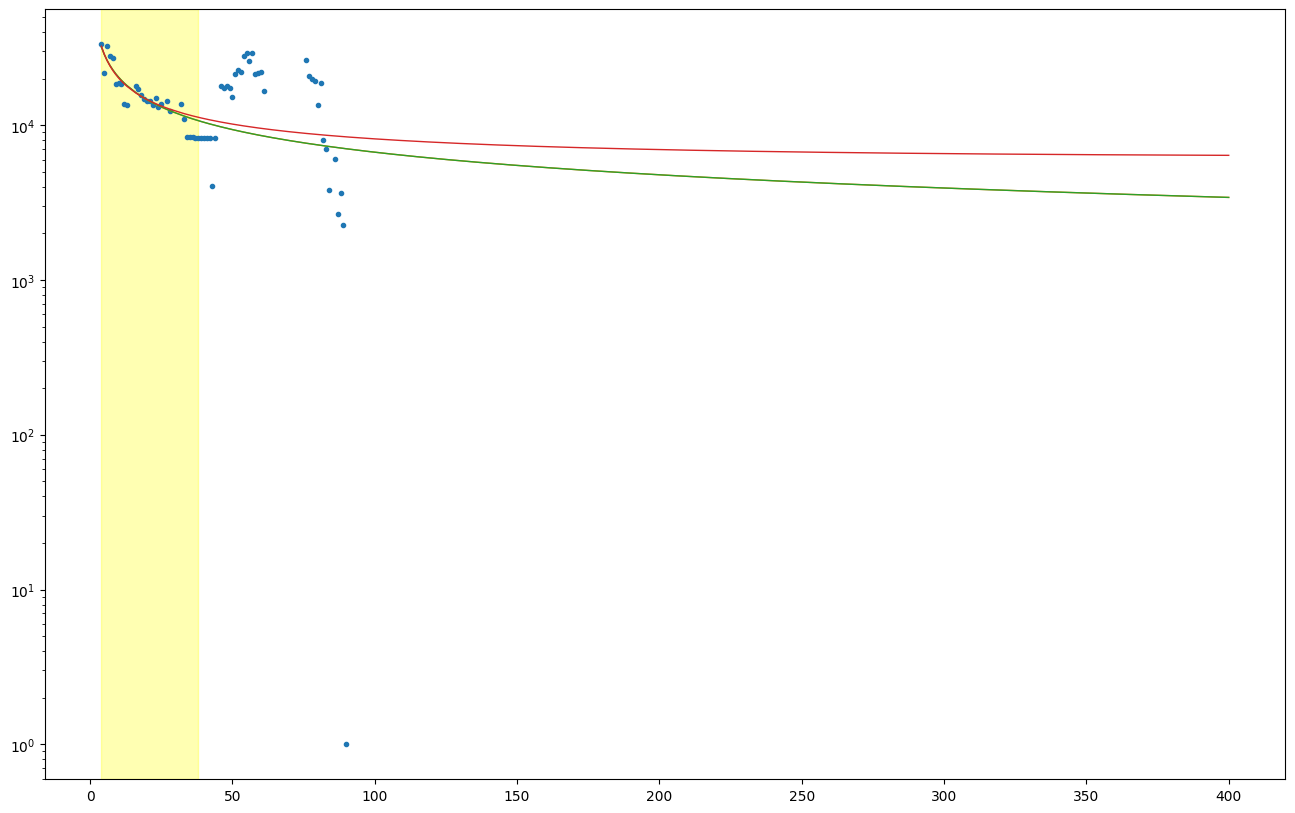

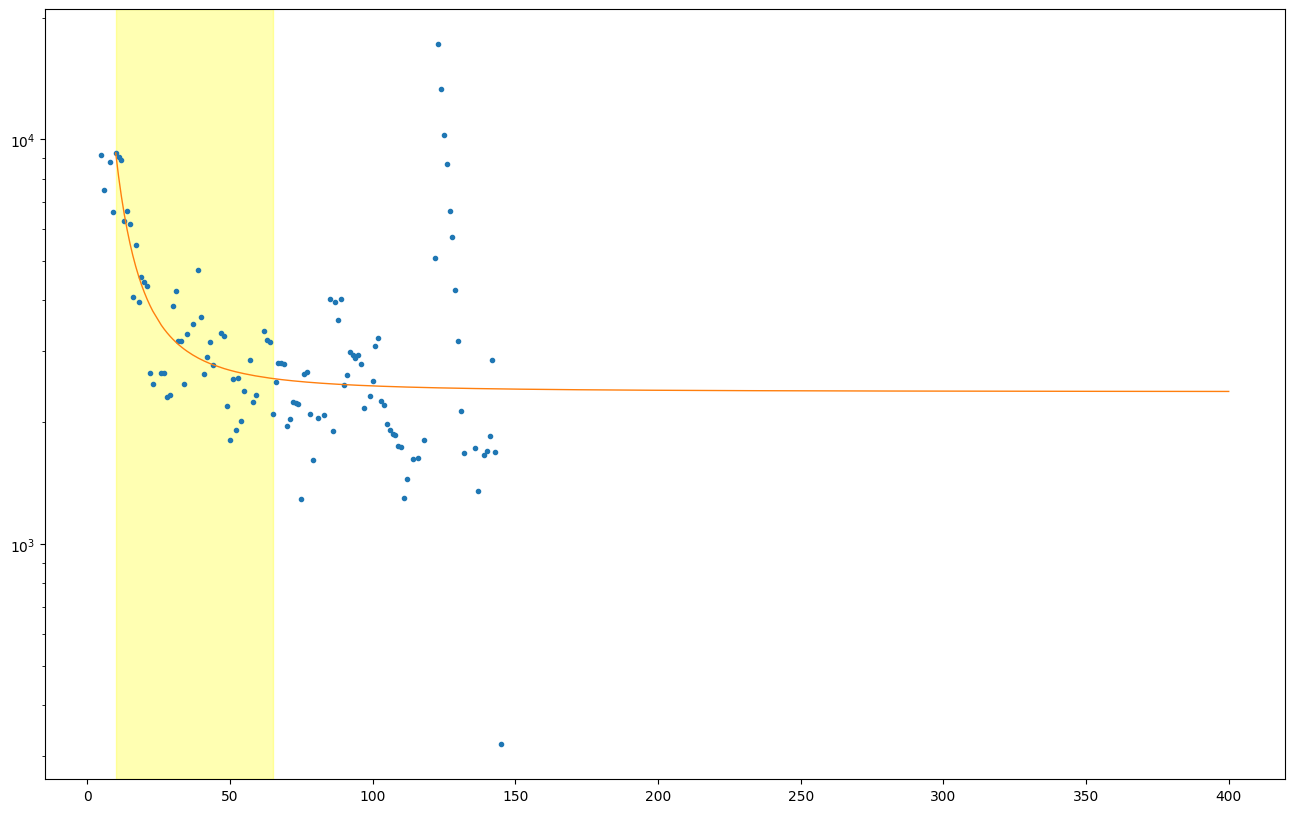

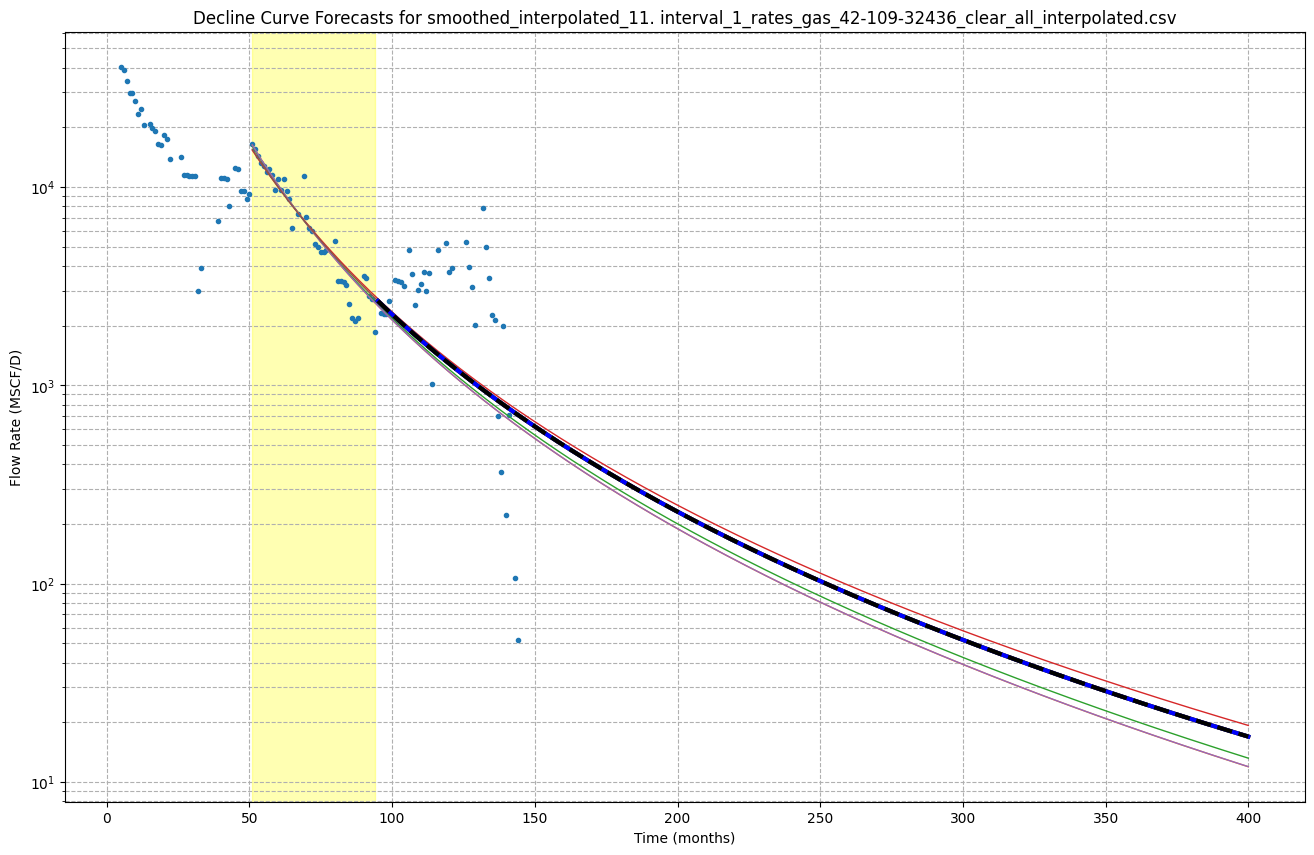

Error fitting model stretched_exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model vdma: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model stretched_exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model vdma: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model stretched_exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model vdma: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model stretched_exponential: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
Error fitting model vdma: Optimal parameters not found: Number of calls to function has reached maxfev = 20000.
No valid models for smoothed_interpo

In [1]:
# This script fits several Decline Curve Analysis (DCA) models to production data, evaluates model performance
# using various metrics, and calculates forecasts and percentiles of the forecasted production. It supports
# different optimization techniques for parameter estimation and visualizes the results.

# Import necessary libraries
import os  # For interacting with the file system
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis with DataFrames
from scipy.optimize import curve_fit, differential_evolution, dual_annealing  # For optimization and curve fitting
import matplotlib.pyplot as plt  # For creating visualizations
import warnings  # For handling warnings
import re  # For regular expressions to find patterns in strings
from scipy.signal import find_peaks  # For detecting peaks in data
from statsmodels.nonparametric.smoothers_lowess import lowess  # For LOWESS smoothing

# Define various Decline Curve Analysis (DCA) models

# Arps Hyperbolic model
def arps_hyperbolic(t, qi, Di, b):
    """
    Arps Hyperbolic model for production decline.
    
    Args:
    t (np.ndarray): Time values.
    qi (float): Initial production rate.
    Di (float): Initial decline rate.
    b (float): Hyperbolic exponent.

    Returns:
    np.ndarray: Production rate at each time value.
    """
    with np.errstate(invalid='ignore', over='ignore'):  # Ignore warnings for invalid operations
        result = qi / ((1 + b * Di * t) ** (1 / b))  # Calculate production rate
        result = np.where(np.isfinite(result), result, 0)  # Replace invalid results with 0
        return result

# Logistic Growth model
def logistic_growth(t, qi, aLGM, nLGM):
    """
    Logistic Growth model for production decline.

    Args:
    t (np.ndarray): Time values.
    qi (float): Initial production rate.
    aLGM (float): Logistic growth parameter.
    nLGM (float): Logistic growth exponent.

    Returns:
    np.ndarray: Production rate at each time value.
    """
    with np.errstate(invalid='ignore', over='ignore'):
        result = qi * (nLGM - aLGM * t ** (nLGM - 1)) / ((aLGM + t ** nLGM) ** 2)
        return np.where(np.isfinite(result), result, 0)

# Stretched Exponential model
def stretched_exponential(t, qi, tau, n):
    """
    Stretched Exponential model for production decline.

    Args:
    t (np.ndarray): Time values.
    qi (float): Initial production rate.
    tau (float): Characteristic time constant.
    n (float): Stretching exponent.

    Returns:
    np.ndarray: Production rate at each time value.
    """
    with np.errstate(invalid='ignore', over='ignore'):
        result = qi * np.exp(-(t / tau) ** n)
        return np.where(np.isfinite(result), result, 0)

# Power Law model
def power_law(t, qi, Di, beta):
    """
    Power Law model for production decline.

    Args:
    t (np.ndarray): Time values.
    qi (float): Initial production rate.
    Di (float): Decline rate.
    beta (float): Power law exponent.

    Returns:
    np.ndarray: Production rate at each time value.
    """
    with np.errstate(invalid='ignore', over='ignore'):
        result = qi * (1 + beta * Di * t) ** (-1 / beta)
        return np.where(np.isfinite(result), result, 0)

# Duong model
def duong(t, qi, aD, mD):
    """
    Duong model for production decline.

    Args:
    t (np.ndarray): Time values.
    qi (float): Initial production rate.
    aD (float): Duong model parameter.
    mD (float): Duong model exponent.

    Returns:
    np.ndarray: Production rate at each time value.
    """
    with np.errstate(invalid='ignore', over='ignore'):
        result = qi * t ** (-mD) * np.exp((aD / (1 - mD)) * (t ** (1 - mD) - 1))
        return np.where(np.isfinite(result), result, 0)

# Wang model
def wang(t, qi, lambda_W):
    """
    Wang model for production decline.

    Args:
    t (np.ndarray): Time values.
    qi (float): Initial production rate.
    lambda_W (float): Wang model parameter.

    Returns:
    np.ndarray: Production rate at each time value.
    """
    with np.errstate(invalid='ignore', over='ignore'):
        result = qi * np.exp(-lambda_W * (np.log(t)) ** 2)
        return np.where(np.isfinite(result), result, 0)

# VDMA model
def vdma(t, qi, Di, n_VDMA):
    """
    VDMA model for production decline.

    Args:
    t (np.ndarray): Time values.
    qi (float): Initial production rate.
    Di (float): Decline rate.
    n_VDMA (float): VDMA model exponent.

    Returns:
    np.ndarray: Production rate at each time value.
    """
    with np.errstate(invalid='ignore', over='ignore'):
        result = qi * np.exp(-Di * t ** (1 - n_VDMA))
        return np.where(np.isfinite(result), result, 0)

# Sum of squared errors function for Differential Evolution
def sum_of_squared_errors(parameter_tuple, model_func, t, flow_rate):
    """
    Calculates the sum of squared errors between model predictions and actual data.

    Args:
    parameter_tuple (tuple): Model parameters.
    model_func (callable): DCA model function.
    t (np.ndarray): Time values.
    flow_rate (np.ndarray): Actual production rates.

    Returns:
    float: Sum of squared errors.
    """
    warnings.filterwarnings("ignore")  # Ignore warnings
    val = model_func(t, *parameter_tuple)  # Compute model values with given parameters
    return np.sum((flow_rate - val) ** 2.0)  # Compute sum of squared errors

# Generate initial parameters using Differential Evolution
def generate_initial_parameters(model_func, t, flow_rate, bounds):
    """
    Generates initial parameters for model fitting using Differential Evolution.

    Args:
    model_func (callable): DCA model function.
    t (np.ndarray): Time values.
    flow_rate (np.ndarray): Actual production rates.
    bounds (list): Bounds for the model parameters.

    Returns:
    np.ndarray: Initial parameter estimates.
    """
    result = differential_evolution(sum_of_squared_errors, bounds, args=(model_func, t, flow_rate), seed=3)
    return result.x

# Fit to decline curve models by regression
def fit_decline_model(model_func, time, flow_rate, initial_bounds, method, lmfit_method=None):
    """
    Fits a DCA model to the production data using specified optimization method.

    Args:
    model_func (callable): DCA model function.
    time (np.ndarray): Time values.
    flow_rate (np.ndarray): Actual production rates.
    initial_bounds (list): Bounds for the model parameters.
    method (int): Method for fitting (1: Differential Evolution, 2: Dual Annealing, 3: Gaussian Process, 4: Particle Swarm, 5: LMFIT).
    lmfit_method (str, optional): LMFIT method for optimization.

    Returns:
    list: Fitted model parameters, or None if fitting fails.
    """
    if len(flow_rate) == 0:
        return None  # Return None if there are no flow rate data points
    try:
        if method == 1:  # Use Differential Evolution for initial parameters
            initial_guess = generate_initial_parameters(model_func, time, flow_rate, initial_bounds)
            params, _ = curve_fit(model_func, time, flow_rate, p0=initial_guess, maxfev=20000)
        elif method == 2:  # Use Dual Annealing optimization method
            bounds = initial_bounds
            result = dual_annealing(sum_of_squared_errors, bounds=bounds, args=(model_func, time, flow_rate))
            params = result.x
        elif method == 3:  # Use Gaussian Process minimization
            from skopt import gp_minimize
            bounds = initial_bounds
            result = gp_minimize(lambda x: sum_of_squared_errors(x, model_func, time, flow_rate), bounds)
            params = result.x
        elif method == 4:  # Use Particle Swarm Optimization
            from pyswarm import pso
            lb, ub = zip(*initial_bounds)
            params, _ = pso(sum_of_squared_errors, lb, ub, args=(model_func, time, flow_rate))
        elif method == 5:  # Use LMFIT library
            from lmfit import Model
            model = Model(model_func)
            params = model.make_params()
            result = model.fit(flow_rate, params, t=time, method=lmfit_method)
            params = list(result.best_values.values())
        return params  # Return fitted parameters
    except RuntimeError as e:
        print(f"Error fitting model {model_func.__name__}: {e}")
        return None  # Return None if an error occurred during fitting

# Calculate Adjusted R-squared value
def calculate_adjusted_r_squared(model_func, time, flow_rate, params):
    """
    Calculates the adjusted R-squared value for a fitted model.

    Args:
    model_func (callable): DCA model function.
    time (np.ndarray): Time values.
    flow_rate (np.ndarray): Actual production rates.
    params (list): Fitted model parameters.

    Returns:
    float: Adjusted R-squared value.
    """
    residuals = flow_rate - model_func(time, *params)  # Calculate residuals
    ss_res = np.sum(residuals**2)  # Sum of squared residuals
    ss_tot = np.sum((flow_rate - np.mean(flow_rate))**2)  # Total sum of squares
    r_squared = 1 - (ss_res / ss_tot)  # Calculate R-squared
    n = len(flow_rate)  # Number of observations
    p = len(params)  # Number of parameters
    adjusted_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)  # Adjusted R-squared
    return adjusted_r_squared

# Calculate mean absolute metric
def mean_abs_metric(y_true, y_pred, eps=0.001):
    """
    Calculates the mean absolute percentage accuracy between true and predicted values.

    Args:
    y_true (np.ndarray): True values.
    y_pred (np.ndarray): Predicted values.
    eps (float): Small epsilon value to avoid division by zero.

    Returns:
    int: Mean absolute percentage accuracy (percentage).
    """
    percentage_diff_list = []
    for idx in range(len(y_true)):
        diff = np.abs(y_true[idx] - y_pred[idx])
        error = np.clip(diff / np.maximum(y_true[idx] + y_pred[idx], eps), 0, 1)
        accuracy = 1 - error
        percentage_diff_list.append(accuracy)
    mean_abs_perc_accur = int(np.round(np.mean(percentage_diff_list) * 100))  # Mean absolute percentage accuracy
    return mean_abs_perc_accur

# Calculate error metrics for the test data
def calculate_error_metrics(model_func, time, actual, params):
    """
    Calculates various error metrics for a fitted model.

    Args:
    model_func (callable): DCA model function.
    time (np.ndarray): Time values.
    actual (np.ndarray): Actual production rates.
    params (list): Fitted model parameters.

    Returns:
    tuple: Mean Absolute Error, Mean Squared Error, Root Mean Squared Error, R-squared, Adjusted R-squared, Mean Absolute Percentage Accuracy.
    """
    predicted = model_func(time, *params)  # Predicted values from the model
    mae = np.mean(np.abs(actual - predicted))  # Mean Absolute Error
    mse = np.mean((actual - predicted)**2)  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error
    
    # Calculate R-squared
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    # Calculate adjusted R-squared
    n = len(actual)
    k = len(params)
    adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))
    
    # Calculate mean absolute percentage accuracy
    mean_abs_perc_accur = mean_abs_metric(actual, predicted)
    
    return mae, mse, rmse, r_squared, adj_r_squared, mean_abs_perc_accur

# Function to find peaks and troughs with a minimum height condition
def find_peaks_and_troughs(smoothed_values, min_peak_rel_height=0.2):
    """
    Identifies peaks and troughs in smoothed production data.

    Args:
    smoothed_values (np.ndarray): Smoothed production data.
    min_peak_rel_height (float): Minimum relative height condition for peak filtering.

    Returns:
    tuple: Arrays of valid peak and trough indices.
    """
    peaks, _ = find_peaks(smoothed_values)  # Detect peaks in the smoothed values
    valid_peaks = []

    # Filter peaks based on the minimum relative height condition
    if len(peaks) > 0:
        valid_peaks.append(peaks[0])  # Add the first peak
        for i in range(1, len(peaks)):
            if smoothed_values[peaks[i]] >= min_peak_rel_height * smoothed_values[valid_peaks[-1]]:
                valid_peaks.append(peaks[i])  # Add valid peaks based on relative height
    
    max_value_idx = np.argmax(smoothed_values)  # Index of the maximum value in the smoothed values
    if max_value_idx not in valid_peaks:
        valid_peaks.append(max_value_idx)  # Ensure the maximum value is included in the peaks
    
    troughs, _ = find_peaks(-smoothed_values)  # Detect troughs by finding peaks in the negative values
    
    if len(smoothed_values) >= 5:
        last_5_points = smoothed_values[-5:]
        min_last_5_idx = np.argmin(last_5_points) + (len(smoothed_values) - 5)
        if min_last_5_idx not in troughs:
            troughs = np.append(troughs, min_last_5_idx)  # Include minimum point in the last 5 values as a trough

    # Ensure the last point is considered a trough if it is the minimum
    if smoothed_values[-1] == np.min(smoothed_values) and len(smoothed_values) > 1:
        if len(troughs) == 0 or troughs[-1] != len(smoothed_values) - 1:
            troughs = np.append(troughs, len(smoothed_values) - 1)

    return np.array(valid_peaks), np.array(troughs)  # Return arrays of valid peaks and troughs

# Function to identify the best fitting period
def identify_best_fitting_period(t, smoothed_values, peaks, troughs, min_months=30):
    """
    Identifies the best fitting period for model calibration based on peaks and troughs.

    Args:
    t (pd.Series): Time data.
    smoothed_values (np.ndarray): Smoothed production data.
    peaks (np.ndarray): Indices of peaks.
    troughs (np.ndarray): Indices of troughs.
    min_months (int): Minimum duration for a fitting period.

    Returns:
    tuple: Start and end of the best fitting period.
    """
    fitting_periods = []  # List to store fitting periods
    peaks = np.sort(peaks)  # Sort peaks to ensure correct order
    
    # Iterate through peaks from last to first
    for i in range(len(peaks) - 1, -1, -1):
        peak_idx = peaks[i]
        following_troughs = troughs[troughs > peak_idx]  # Find troughs after the current peak
        if len(following_troughs) > 0:
            trough_idx = following_troughs[0]  # Select the first trough after the peak
            if (t.iloc[trough_idx] - t.iloc[peak_idx]) > min_months:
                fitting_periods.append((t.iloc[peak_idx], t.iloc[trough_idx]))  # Add to fitting periods if duration is sufficient
    
    # If no valid fitting period is found, try with second last peak
    if not fitting_periods:
        for i in range(len(peaks) - 2, -1, -1):
            peak_idx = peaks[i]
            following_troughs = troughs[troughs > peak_idx]
            if len(following_troughs) > 0:
                trough_idx = following_troughs[0]
                fitting_periods.append((t.iloc[peak_idx], t.iloc[trough_idx]))

    # If still no fitting periods, use the last peak and trough
    if not fitting_periods:
        last_peak_idx = peaks[-1]
        last_trough_idx = troughs[-1]
        return t.iloc[last_peak_idx], t.iloc[last_trough_idx]

    # Return the longest fitting period
    return max(fitting_periods, key=lambda period: period[1] - period[0])

# Function to validate the best fitting period
def validate_fitting_period(t, smoothed_values, q_actual, peaks, troughs, min_months=30):
    """
    Validates and adjusts the best fitting period based on local maxima and duration constraints.

    Args:
    t (pd.Series): Time data.
    smoothed_values (np.ndarray): Smoothed production data.
    q_actual (pd.Series): Actual production data.
    peaks (np.ndarray): Indices of peaks.
    troughs (np.ndarray): Indices of troughs.
    min_months (int): Minimum duration for a fitting period.

    Returns:
    tuple: Validated start and end of the best fitting period.
    """
    best_start, best_end = identify_best_fitting_period(t, smoothed_values, peaks, troughs, min_months)
    
    # Ensure best_start and best_end are in the peak and trough lists
    while not ((best_start in t.iloc[peaks].values) and (best_end in t.iloc[troughs].values)):
        best_start, best_end = identify_best_fitting_period(t, smoothed_values, peaks[:-1], troughs, min_months)
        if len(peaks) < 2:
            break
        peaks = peaks[:-1]

    # Additional validation for best_start
    best_start_idx = t[t == best_start].index[0]
    pre_range = q_actual[max(0, best_start_idx - 10):best_start_idx]
    post_range = q_actual[best_start_idx+1:min(len(q_actual), best_start_idx + 11)]

    pre_max = pre_range.max() if pre_range.size > 0 else -np.inf
    post_max = post_range.max() if post_range.size > 0 else -np.inf

    # Adjust best_start if it is not a local maximum
    if q_actual[best_start_idx] < pre_max or q_actual[best_start_idx] < post_max:
        if pre_max > post_max:
            best_start = t.iloc[pre_range.argmax() + max(0, best_start_idx - 10)]
        else:
            best_start = t.iloc[post_range.argmax() + best_start_idx + 1]
    
    return best_start, best_end  # Return the validated best fitting period

# Prepare curves for plotting with common time values
def prepare_curves_for_plotting(models, data, start_forecast_time):
    """
    Prepares forecasted curves for plotting by aligning time values.

    Args:
    models (dict): Dictionary of DCA model functions.
    data (dict): Dictionary containing model data and parameters.
    start_forecast_time (int): The starting time for forecast.

    Returns:
    tuple: Common time array and dictionary of forecasted curves.
    """
    forecasted_curves = {}
    max_length = 0
    
    # Determine the longest forecasted time
    for model_data in data.values():
        if len(model_data['forecasted_t']) > max_length:
            max_length = len(model_data['forecasted_t'])
    
    # Create common time array
    common_t = np.arange(start_forecast_time, start_forecast_time + max_length)
    
    # Compute forecasted values for each model
    for key, model_data in data.items():
        model_name = key.split()[-1]  # Extract model name from key
        forecasted_q = models[model_name](common_t, *model_data['params'])  # Compute forecast
        forecasted_curves[key] = forecasted_q  # Store forecasted values
        
    return common_t, forecasted_curves

# Calculate P10, P50, P90 percentiles of the forecasted curves
def calculate_percentiles(forecasted_curves):
    """
    Calculates the P10, P50, and P90 percentiles of forecasted production curves.

    Args:
    forecasted_curves (dict): Dictionary of forecasted curves.

    Returns:
    tuple: Arrays of P10, P50, and P90 percentiles.
    """
    forecasted_values = np.array(list(forecasted_curves.values()))  # Convert to numpy array
    if forecasted_values.size == 0:
        raise ValueError("No forecasted values available to calculate percentiles.")
    p10 = np.percentile(forecasted_values, 10, axis=0)  # Calculate 10th percentile
    p50 = np.percentile(forecasted_values, 50, axis=0)  # Calculate 50th percentile
    p90 = np.percentile(forecasted_values, 90, axis=0)  # Calculate 90th percentile
    
    return p10, p50, p90

# Calculate average forecasted curve
def calculate_average_curve(forecasted_curves):
    """
    Calculates the average forecasted production curve.

    Args:
    forecasted_curves (dict): Dictionary of forecasted curves.

    Returns:
    np.ndarray: Average forecasted curve.
    """
    forecasted_values = np.array(list(forecasted_curves.values()))  # Convert to numpy array
    if forecasted_values.size == 0:
        raise ValueError("No forecasted values available to calculate the average curve.")
    average_curve = np.mean(forecasted_values, axis=0)  # Compute mean of forecasts
    
    return average_curve

# Calculate Percentiles Based on Flow Rate Steps
def calculate_percentiles_based_on_flowrate(forecasted_curves):
    """
    Calculates percentiles and average production based on flow rate steps.

    Args:
    forecasted_curves (dict): Dictionary of forecasted curves.

    Returns:
    tuple: Arrays of P10, P50, P90 percentiles, and average values based on flow rate.
    """
    forecasted_values = np.array(list(forecasted_curves.values()))  # Convert to numpy array
    if forecasted_values.size == 0:
        raise ValueError("No forecasted values available to calculate percentiles.")
    
    # Determine common flow rate steps
    min_flowrate = np.min(forecasted_values[:, -1])  # Minimum flow rate at the end of the forecast
    max_flowrate = np.max(forecasted_values[:, 0])  # Maximum flow rate at the start of the forecast
    common_flowrates = np.linspace(min_flowrate, max_flowrate, num=100)  # Generate 100 common flow rate steps
    
    p10 = []
    p50 = []
    p90 = []
    avg = []
    
    # Calculate percentiles and average at each flow rate step
    for flowrate in common_flowrates:
        values_at_flowrate = []
        for curve in forecasted_values:
            value = np.interp(flowrate, np.flip(curve), np.arange(len(curve)))  # Interpolate values
            values_at_flowrate.append(value)
        p10.append(np.percentile(values_at_flowrate, 10))
        p50.append(np.percentile(values_at_flowrate, 50))
        p90.append(np.percentile(values_at_flowrate, 90))
        avg.append(np.mean(values_at_flowrate))
    
    return np.array(p10), np.array(p50), np.array(p90), np.array(avg)  # Return arrays of percentiles and average values

# This script processes smoothed CSV files to forecast decline curves using various Decline Curve Analysis (DCA) models.
# It evaluates model performance, forecasts production, calculates percentiles and EUR, and outputs results based on user options.

# Function to process smoothed CSV files and forecast decline curves
def process_smoothed_csv_files(directory, forecast_method, forecast_end_time=None, forecast_end_flow_rate_gas=None, forecast_end_flow_rate_oil=None, output_option=1):
    """
    Processes smoothed CSV files to fit and forecast decline curves using selected DCA models.

    Args:
    directory (str): Directory containing smoothed CSV files.
    forecast_method (int): Method for forecasting (1 for end time, 2 for end flow rate).
    forecast_end_time (int, optional): Forecast end time in months.
    forecast_end_flow_rate_gas (float, optional): Forecast end flow rate for gas wells.
    forecast_end_flow_rate_oil (float, optional): Forecast end flow rate for oil wells.
    output_option (int): Output option (1: plot only, 2: plot and save, 3: save only).

    Returns:
    tuple: List of filenames processed and results for each file.
    """
    files_with_issues = []  # List to store files with zero or NaN values
    files_to_process = []  # List to store files that are ready for processing
    summary_data = []  # List to store summary data for each file
    eur_data = []  # List to store EUR data for each file

    # Check each file for zero or NaN values
    for filename in os.listdir(directory):
        if filename.endswith(".csv") and "smoothed" in filename:  # File name to process
            file_path = os.path.join(directory, filename)  # Full path of the file
            data = pd.read_csv(file_path)  # Read CSV file into a DataFrame

            # Check if necessary columns are present
            if 't' not in data.columns or 'q_actual' not in data.columns:
                print(f"File {filename} does not have the necessary columns for processing.")
                continue

            # Check for zero or NaN values
            if data.isnull().values.any() or (data == 0).values.any():
                files_with_issues.append(filename)  # Add file to issues list
            else:
                files_to_process.append(filename)  # Add file to process list

    # Print the files with issues and ask user to proceed
    if files_with_issues:
        print("The following files contain zero or NaN values:")
        for file in files_with_issues:
            print(file)
        user_input = input("Do you want to proceed by excluding these files? (yes/no): ")
        if user_input.lower() != 'yes':
            print("Exiting...")
            return

    all_filenames = []  # List to store all filenames processed
    results = []  # List to store results for each file
    wells_with_valid_model = 0  # Counter for wells with valid models
    wells_with_any_model = 0  # Counter for wells with any fitted model

    # Prompt user to select fitting technique
    method = int(input("Select fitting technique (1 for curve_fit, 2 for dual_annealing, 3 for Bayesian Optimization, 4 for PSO, 5 for lmfit)(Default is 1, i.e. curve_fit): ") or 1)
    lmfit_method = None
    if method == 5:
        optimization_methods = [
            'leastsq',               # Levenberg-Marquardt
            'nelder',                # Nelder-Mead
            'nelder-mead',           # Nelder-Mead (alternative)
            'powell',                # Powell
            'cg',                    # Conjugate Gradient
            'bfgs',                  # BFGS
            'newton',                # Newton-Conjugate Gradient
            'newton-cg',             # Newton-Conjugate Gradient (alternative)
            'lbfgsb',                # L-BFGS-B
            'L-BFGS-B',              # L-BFGS-B (alternative)
            'tnc',                   # Truncated Newton
            'cobyla',                # Constrained Optimization BY Linear Approximations
            'slsqp',                 # Sequential Least Squares Programming
            'differential_evolution',# Differential Evolution
            'trf',                   # Trust Region Reflective
            'dogleg',                # Dogleg
            'ampgo'                  # Adaptive Memory Programming for Global Optimization
        ]
        print("Choose an lmfit optimization method from the following:")
        for i, opt_method in enumerate(optimization_methods, start=1):
            print(f"{i}. {opt_method}")
        lmfit_method_choice = int(input("Enter the number of the method you choose: "))
        lmfit_method = optimization_methods[lmfit_method_choice - 1]  # Get user's choice for lmfit method

    # Dictionary of DCA models
    models = {
        'Arps_Hyperbolic': arps_hyperbolic,
        'Logistic_Growth': logistic_growth,
        'Stretched_Exponential': stretched_exponential,
        'Power_Law': power_law,
        'Duong': duong,
        'Wang': wang,
        'VDMA': vdma,      
    }

    # Prompt user to select models for fitting
    selected_models_input = input(("Enter DCA model/s you want to use (e.g., '1,2,3' or 'all') ( 1.Arps, 2.LGM, 3.SEPD, 4.PLE, 5.Duong, 6.Wang, 7.VDMA): ") )
    if selected_models_input.lower() == 'all':
        selected_models = list(models.keys())
    else:
        selected_models_indices = list(map(int, selected_models_input.split(',')))
        selected_models = [list(models.keys())[i-1] for i in selected_models_indices]  # Get user's choice of models

    # Process each file in the list of files to process
    for filename in files_to_process:
        file_path = os.path.join(directory, filename)
        data = pd.read_csv(file_path)

        t = data['t']  # Time data
        q_actual = data['q_actual']         
        # Ensure t is a pandas Series
        if not isinstance(t, pd.Series):
            t = pd.Series(t)
        
        smoothed_columns = [col for col in data.columns if col != 't']  # Exclude 't' column

        # Apply LOWESS smoothing to q_actual
        q_smoothed_lowess = lowess(q_actual, t, frac=frac, return_sorted=False)

        # Find peaks and troughs
        peaks, troughs = find_peaks_and_troughs(q_smoothed_lowess, min_peak_rel_height=0.2)

        # Validate the best fitting period based on peaks and troughs
        best_start, best_end = validate_fitting_period(t, q_smoothed_lowess, q_actual, peaks, troughs, min_months=30)

        # Get indices for best_start and best_end
        start_idx = t[t == best_start].index[0]
        end_idx = t[t == best_end].index[0]

        # Update forecast start time to be the best_end of the fitting period
        start_forecast_time = t.iloc[end_idx] + 1

        # Create a complete time range from the start of fitting to the end of forecasting
        full_time_range = pd.Series(np.arange(t[start_idx], start_forecast_time + (forecast_end_time if forecast_end_time else t.max()), 1))

        # Plot initial data if output_option is 1 or 2
        if output_option in [1, 2]:
            plt.figure(figsize=(16, 10))
            plt.semilogy(t, q_actual, 'o', label='q_actual', markersize=3)
            plt.axvspan(t.iloc[start_idx], t.iloc[end_idx], color='yellow', alpha=0.3)

        well_has_valid_model = False  # Flag to check if the well has a valid model
        well_has_any_model = False  # Flag to check if the well has any model

        well_results = pd.DataFrame({'time': full_time_range})  # DataFrame to store results for the well

        # Iterate over smoothed columns
        for col in smoothed_columns:
            data_values = data[col].values
            fitting_t = t[start_idx:end_idx+1]
            fitting_data = data_values[start_idx:end_idx+1]

            # Split the data into training and testing
            split_index = int(len(fitting_t) * 0.8)
            train_t = fitting_t[:split_index]
            train_data = fitting_data[:split_index]
            test_t = fitting_t[split_index:]
            test_data = fitting_data[split_index:]

            # Check if there is sufficient data for training and testing
            if len(train_data) < minimum_production_history or len(test_data) < 1:
                print(f"Insufficient data for training or testing in file {filename} for column {col}. Skipping this model.")
                continue

            qi_initial = np.max(fitting_data)  # Initial guess for qi
            # Define initial bounds for each model
            initial_bounds = {
                'Arps_Hyperbolic': [(qi_initial*0.5, qi_initial*5), (0.0001, 0.1), (0.0001, 4)],
                'Logistic_Growth': [(qi_initial*1000, qi_initial*15000), (10, 1000), (0.00001, 1.5)],
                'Stretched_Exponential': [(qi_initial*0.5, qi_initial*1.5), (0.001, 2), (0.001, 2)],
                'Power_Law': [(qi_initial*0.5, qi_initial*1.5), (0.0001, 2), (0.0001, 2)],
                'Duong': [(qi_initial*0.5, qi_initial*1.5), (0.01, 10), (0.5, 1.5)],
                'Wang': [(qi_initial*0.5, qi_initial*1.5), (0.0001, 10)],
                'VDMA': [(qi_initial*0.5, qi_initial*1.5), (0.00001, 2), (0.1, 2)],
            }

            fitted_models_data = {}  # Dictionary to store data for fitted models

            # Iterate over selected models
            for model_name in selected_models:
                model_func = models[model_name]  # Get model function
                params = fit_decline_model(model_func, train_t, train_data, initial_bounds[model_name], method, lmfit_method)
                if params is None:
                    continue

                adjusted_r_squared = calculate_adjusted_r_squared(model_func, train_t, train_data, params)
                if adjusted_r_squared < 0.8:
                    continue

                # Calculate error metrics on the test data
                mae, mse, rmse, r_squared, adj_r_squared, mean_abs_perc_accur = calculate_error_metrics(model_func, test_t, test_data, params)

                forecasted_q = []  # List to store forecasted values
                current_time = start_forecast_time

                # Forecast until end time or flow rate condition is met
                while True:
                    forecasted_value = model_func(current_time, *params)
                    forecasted_q.append(forecasted_value)

                    if forecast_method == 1 and current_time >= forecast_end_time:
                        break
                    if forecast_method == 2:
                        if 'oil' in filename.lower():
                            if forecasted_value <= forecast_end_flow_rate_oil or current_time >= forecast_end_time:
                                break
                        if 'gas' in filename.lower():
                            if forecasted_value <= forecast_end_flow_rate_gas or current_time >= forecast_end_time:
                                break

                    current_time += 1

                forecasted_q = np.array(forecasted_q)  # Convert forecasted values to numpy array
                forecast_time_range = np.arange(start_forecast_time, start_forecast_time + len(forecasted_q), 1)
                
                # Combine both fitted and forecasted data for plotting and saving
                combined_t = np.concatenate([train_t, test_t, forecast_time_range])
                combined_q = np.concatenate([model_func(train_t, *params), model_func(test_t, *params), forecasted_q])
                
                # Check if the model meets accuracy thresholds
                if adjusted_r_squared > (fitting_accurcy_threshold/100) and mean_abs_perc_accur >= prediction_accurcy_threshold and (forecasted_q[-1] >= 3 if forecast_end_time else True):
                    print(f'{col} {model_name} Adjusted R-squared_Fit: {adjusted_r_squared:.4f}')
                    print(f'{col} {model_name} MAE_Test: {mae:.4f}, MSE_Test: {mse:.4f}, RMSE_Test: {rmse:.4f}, R2_Test: {r_squared:.4f}, Adjusted_R2_Test: {adj_r_squared:.4f}, Mean_Abs_Perc_Acc: {mean_abs_perc_accur:.4f}')
                    
                    # Plot the combined data if output_option is 1 or 2
                    if output_option in [1, 2]:
                        plt.semilogy(combined_t, combined_q, label=f'{col} {model_name}', linewidth=1)

                    # Save the data for percentile calculations
                    fitted_models_data[f'{col} {model_name}'] = {
                        'params': params,
                        'forecasted_t': forecast_time_range,
                        'forecasted_q': forecasted_q
                    }

                    # Collect data for summary CSV
                    param_names = model_func.__code__.co_varnames[1:model_func.__code__.co_argcount]
                    summary_data.append({
                        'well_name': filename,
                        'model_name': model_name,
                        'adjusted_r_squared_fit': adjusted_r_squared,
                        'mae_test': mae,
                        'mse_test': mse,
                        'rmse_test': rmse,
                        'r2_test': r_squared,
                        'adjusted_r2_test': adj_r_squared,
                        'mean_abs_perc_accur': mean_abs_perc_accur,
                        'params': '\n'.join([f"{param_name}: {param}" for param_name, param in zip(param_names, params)])
                    })
                    well_has_valid_model = True
                    well_has_any_model = True

                    # Align the length of combined_q with well_results index using reindex
                    combined_q_series = pd.Series(combined_q, index=combined_t)
                    combined_q_series = combined_q_series.reindex(full_time_range, fill_value=np.nan)
                    well_results[f'{col}_{model_name}_flowrate'] = combined_q_series

        # Update counters for wells with any model or valid model
        if well_has_any_model:
            wells_with_any_model += 1

        if well_has_valid_model:
            wells_with_valid_model += 1

        # Prepare curves for plotting
        if not fitted_models_data:
            print(f"No valid models for {filename}. Skipping percentile calculation.")
            all_filenames.append(filename)
            results.append(None)
            continue

        # Calculate percentiles and average curve for forecasted data
        if forecast_method == 1:
            common_t, forecasted_curves = prepare_curves_for_plotting(models, fitted_models_data, start_forecast_time)
            p10, p50, p90 = calculate_percentiles(forecasted_curves)
            average_curve = calculate_average_curve(forecasted_curves)
            
            if output_option in [1, 2]:
                # Plot P10, P50, P90, and average curves
                plt.semilogy(common_t, p10, label='P90', linewidth=3, color='red')
                plt.semilogy(common_t, p50, label='P50', linewidth=3, color='green')
                plt.semilogy(common_t, p90, label='P10', linewidth=3, color='blue')
                plt.semilogy(common_t, average_curve, label='Average', linewidth=3, linestyle='--', color='black')

                # Add percentile curves to well_results
                p10_series = pd.Series(p10, index=common_t).reindex(full_time_range, fill_value=np.nan)
                p50_series = pd.Series(p50, index=common_t).reindex(full_time_range, fill_value=np.nan)
                p90_series = pd.Series(p90, index=common_t).reindex(full_time_range, fill_value=np.nan)
                average_series = pd.Series(average_curve, index=common_t).reindex(full_time_range, fill_value=np.nan)

                well_results['P90_flowrate'] = p10_series
                well_results['P50_flowrate'] = p50_series
                well_results['P10_flowrate'] = p90_series
                well_results['Average_flowrate'] = average_series

        # Plot settings and display plot
        if output_option in [1, 2]:
            # Set y-axis label based on filename
            if 'gas' in filename.lower():
                plt.ylabel('Flow Rate (MSCF/D)')
            elif 'oil' in filename.lower():
                plt.ylabel('Flow Rate (STB/D)')

            plt.xlabel('Time (months)')
            plt.title(f'Decline Curve Forecasts for {filename}')
            plt.grid(True, which="both", ls="--")
            #plt.legend()
            plt.show()

        # Save well results to CSV if output_option is 2 or 3
        if output_option in [2, 3]:
            well_results.to_csv(f'{directory}/{filename.replace(".csv", "")}_all_models.csv', index=False)

        # Calculate EUR data for each well
        for idx, filename in enumerate(os.listdir(directory)):
            match = re.search(r'_(\d{2}-\d{3}-\d{5})_', filename)
            if not match:
                print(f"No well id found in {filename}")
                continue
            well_id = match.group(1)

            matching_file = [f for f in os.listdir(directory) if well_id in f and f.endswith(".csv")]
            if not matching_file:
                print(f"No matching file found for {filename}")
                continue
            
            q_actual_file = os.path.join(directory, matching_file[0])
            q_actual_data = pd.read_csv(q_actual_file)
            
            if 'q_actual' not in q_actual_data.columns:
                print(f"No 'q_actual' column in {q_actual_file}")
                continue

            q_original = q_actual_data['q_actual'].values
            
            # Calculate EUR values
            if forecast_method == 1:
                eur_data.append({
                    'well_name': filename,
                    'well_id': well_id,
                    'EUR_P10': np.sum(p10) + np.sum(q_original),
                    'EUR_P50': np.sum(p50) + np.sum(q_original),
                    'EUR_P90': np.sum(p90) + np.sum(q_original),
                    'EUR_Average': np.sum(average_curve) + np.sum(q_original)
                })
            all_filenames.append(filename)
            results.append((common_t, p10, p50, p90, average_curve, q_actual) if forecast_method == 1 else (combined_t, combined_q, q_actual))

    # Print the number of wells with at least one valid model and any fitted model
    print(f"Number of wells with at least one valid model: {wells_with_valid_model}")
    print(f"Number of wells with any fitted model: {wells_with_any_model}")

    # Save the summary CSV
    if output_option in [2, 3] and summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(os.path.join(directory, 'decline_curve_analysis_summary.csv'), index=False)

    # Save EUR data to CSV
    if eur_data:
        eur_df = pd.DataFrame(eur_data)
        eur_df.to_csv(os.path.join(directory, 'EUR_summary.csv'), index=False)

    return all_filenames, results

# Main entry point of the script
if __name__ == "__main__":
    directory = input("Enter the directory path: ")
    q_actual_directory = input("Enter the q_actual_directory path: ")
    forecast_method = int(input("Choose forecasting method (1 for forecast_end_time, 2 for forecast_end_flow_rate) (default is 1): ") or 1)
    forecast_end_time = None
    forecast_end_flow_rate_gas = None
    forecast_end_flow_rate_oil = None
    
    # Get user input for forecast parameters based on the chosen method
    if forecast_method == 1:
        forecast_end_time = int(input("Enter the forecast end time in months (default is 400 months): ") or 400)
        fitting_percent = int(input("Enter How much data for fitting (%) (default is 90%): ") or 90)
        fitting_accurcy_threshold = int(input("Enter the Fitting Accurcy Threshold (%) (default is 90%): ") or 90)
        prediction_accurcy_threshold = int(input("Enter the Prediction Accurcy Threshold (%) (default is 80%): ") or 80)
        minimum_production_history = int(input("Enter the Minimum Production History for a Well Appy DCA (Months) (default is 3 months): ") or 3)
        min_peak_rel_height = float(input("Enter the minimum peak relative height (default 0.2)_Required for fitting period identification: ") or 0.2)
        frac = float(input("Enter the LOWESS smoothing fraction (default 0.30)_Required for fitting period identification: ") or 0.30)
        min_months = int(input("Enter the minimum months for fitting period (default 30)_Required for fitting period identification: ") or 30)
        
    elif forecast_method == 2:
        forecast_end_flow_rate_gas = float(input("Enter the forecast end flow rate for gas wells in MSC/D (default is 100 MSCF/D): ") or 100)
        forecast_end_flow_rate_oil = float(input("Enter the forecast end flow rate for oil wells in STB/D (default is 3 STBD): ") or 3)
        forecast_end_time = int(input("Enter the forecast end time in months (for cases where forecast_end_flow_rate is not reached) (default is 400 months): ") or 400)
        fitting_percent = int(input("Enter How much data for fitting (%) (default is 90%): ") or 90)
        fitting_accurcy_threshold = int(input("Enter the Fitting Accurcy Threshold (%) (default is 90%): ") or 90)
        prediction_accurcy_threshold = int(input("Enter the Prediction Accurcy Threshold (%) (default is 80%): ") or 80)
        minimum_production_history = int(input("Enter the Minimum Production History for a Well Appy DCA (Months) (default is 3 months): ") or 3)
        min_peak_rel_height = float(input("Enter the minimum peak relative height (default 0.2)_Required for fitting period identification: ") or 0.2)
        frac = float(input("Enter the LOWESS smoothing fraction (default 0.30)_Required for fitting period identification: ") or 0.30)
        min_months = int(input("Enter the minimum months for fitting period (default 30)_Required for fitting period identification: ") or 30)
    
    output_option = int(input("Enter 1 to show plots only, 2 to show plots and save results, 3 to save results only (default is 1, i.e. show plots only): ") or 1)
    
    # Process smoothed CSV files with specified forecast method and parameters
    filenames, results = process_smoothed_csv_files(directory, forecast_method, forecast_end_time, forecast_end_flow_rate_gas, forecast_end_flow_rate_oil, output_option)

